# DESCRIPCIÓN SISTEMA LÁSER REMOTO





- Canal emisor: compuesto por un láser de estado sólido y un emisor
- Canal receptor: telescopio de apertura a determinar

Vamos a simular primero la cadena de bombeo de Laser Raman, es decir, la ruta que va desde el laser de emisión hasta la muestra y que incluye los conectores, los switches, la fibra óptica y la lente de focalización.

### Datos del láser


In [29]:
## Datos Láser
# Energia por pulso
E_pulso = 20;       # mJ 
# Ancho de pulso
tau_pulso = 10;    # ns
# Frecuencia de repetición del láser
frp = 20;               
# Número de pulsos emitidos
num_pulsos = 20; 

theta_L = 3;          # mrad
lambda_L = 532;  # nm
# Diametro del haz de salida, típico de una varilla Nd YAG doblada
diam_haz = 3;      # mm

Pot_Promedio = E_pulso * frp;
# Eficiencia de conversión de las especificaciones de Monocrom, caso genérico
eff_conversion = 0.05;

In [30]:
# Potencia eléctrica
Pot_electrica = Pot_Promedio / eff_conversion;    #mW
Pot_electrica = Pot_electrica * 1e-3;    #W

In [31]:
# Tiempo que dura la emisión del láser para tener el tren de pulsos requerido
tau_emitiendo = num_pulsos / frp;

### Datos de propagación

In [32]:
# Distancia a la que está el blanco
alcance = 1;    # km
# Atenuación atmosférica, día despejado. Depende de las condiciones atmosféricas (pagina 316 de CCD Arrays, Cameras and Displays de Holst)
sigma_atten = 0.4;     # km^-1
# Diametro del haz de la muestra
diam_muestra = 10;     # mm
# Aumentos del expansor
beta_expansor = diam_muestra/diam_haz;
# Potencia pico
Pot_pico = E_pulso * 1e-3 / (tau_pulso *1e-9);     # W emitidos del haz colimado
# Potencia muestra 
# El haz es colimado, no vamos a considerar la atenuación por la distancia al cuadrado
from numpy import exp
Pot_muestra = Pot_pico * exp(-sigma_atten * alcance);    # W

mancha_real = diam_haz + 2*np.tan(theta_L*1e-3 / beta_expansor)*alcance*1e5;     # cm

### Calculo de la irradiancia en la muestra

In [33]:
from numpy import pi
Irr_muestra_teo = Pot_muestra / (pi * (diam_muestra*1e-1/2)**2);    # W/cm^2
Irr_muestra = Pot_muestra / (pi * (mancha_real*1e-1/2)**2);      # W/cm^2

### Eficiencia raman para la calcita, se emplea como referencia

In [34]:
lamda = 1086;    # cm^-1
eps_raman_Ca = 1e-8;
lamda_raman_ca = 564.62; # nm
# Irradiancia Raman
Irr_Raman = Irr_muestra*eps_raman_Ca;    # W/cm^2

La muestra se convierte en un emisor lambertiano que emite en π y su flujo debe llegar al cabezal colector que está a una distancia d. 
Convertimos la irradiancia en Radiancia (W/cm^2 str).

In [35]:
Rad_Raman = Irr_Raman/pi;   # W/cm^2 str

Esta superficie emisora es a todos los efectos puntual para el sistema de colección por lo que debemos calcular la intensidad luminosa.

In [36]:
I_emitida = Rad_Raman * (pi*(mancha_real*1e-1/2)**2);
# Cálculo de la intensidad óptica       I = L * S

Si supongo que se observa la fuente puntual en eje entonces: I=I0cos(i) ( ver optica instrumental pagina 83).
La Irradiancia en la apertura de la óptica queda como:

In [37]:
Irr_apertura_optica = I_emitida/(alcance*1e5)**2 * exp(-sigma_atten*alcance);         # W/cm^2

La señal es recogida por el detector que esta a una distancia d.

In [38]:
# Diametro de apertura óptica
D_opt = 10; # cm
# Transmitancia de la óptica
tau_optica = 0.6;

Flujo_coleccion = tau_optica * Irr_apertura_optica * pi * (D_opt/2)**2;      # W que llegan a la óptica

Nota: ahora suponemos que el sisetma de colección es límite por difracción y que la mancha de airy es más
pequeña que el píxel

### Datos del SPECTROMETRO (de la red de difracción)



In [39]:
dispersion = 13;     # nm/mm dispersion del espectrometro
eficiencia = 0.5;     # spectrometer throughput

# spectral_resolution_required = 6 , 8 cm^-1   ;          0.17 , 0.23 nm
# spectral_dispersion_required = 12.6 , 17 nm/mm

### Datos del DETECTOR

In [40]:
OCG = 4.5e-6;       # V/e-
# Tamaño de pixel
px = 0.015;            # mm 
# Números de pixels
N_pixel_H = 2048;
N_pixel_V = 2048;
# Resolución
disp_pix = px * dispersion;

El espectro tiene una anchura de 0.4, 0.5 nm, el cual es recogido en los siguientes pixeles.

In [41]:
bandwidth_Ca = 0.4;     # nm
# ext = floor*(bandwidth_Ca/disp_pix);      # pixels
ext = (bandwidth_Ca/disp_pix);      # pixels

### Detector data

In [42]:
# Velocidad de la luz
c = 3*1e8;         # m/s
h = 6.62*1e-34; # J*s
# Eficiencia Cuántica
QE = 0.6;
# Full well capacity
F_wc = 100*1e3;    # e-

Flujo radiante considerado a cada pixel de la señal Raman

In [43]:
Flujo_px = Flujo_coleccion * eficiencia / round(ext);

Energía Raman recogida por el detector:

In [44]:
Flujo_px_esp = Flujo_px / bandwidth_Ca;       # W/nm per pixel

Calculamos la energía en el detector empleando $\lambda_{Raman _ Ca}$ = 564.62 nm.
No hace falta hacerlo espectralmente (lo dejamos para saber como hacerlo en otros casos), hemos estado considerándolo siempre de forma discreta:

In [45]:
#Cts_r(λ)
def Cts_Raman ( lamda, Flujo_px_esp):
    # global c, h, QE
#     c = 3*1e8;      h=6.62e-34;
    Cts_r =  Flujo_px_esp / (c * h) *lamda * QE;
    return Cts_r

Cts_r = Cts_Raman ( lamda_raman_ca*1e-9, Flujo_px_esp);
# print(Cts_r)

Los fotoelectrones de la señal Raman son calculados en el rango espectral de la señal:

In [46]:
from sympy import integrate       # , init_printing
from sympy.abc import lamda
fun = Flujo_px_esp*1e9 / (c * h) *lamda * QE;
lamda_min = (lamda_raman_ca-bandwidth_Ca/2)*1e-9;
lamda_max = (lamda_raman_ca+bandwidth_Ca/2)*1e-9;
Cts_T = integrate(fun, (lamda, lamda_min, lamda_max));

# print(Cts_T)

El número de fotoelectrones depende del tiempo de integración.
#### La energía por pulso, en cambio, no depende del tiempo.

In [47]:
# Signal(t_i) = Cts_T     para todo t_i
# Fotoelectrones por segundo
# global Signal
Signal = Cts_T;

Transformamos los fotoelectrones detectados a Voltios.

In [48]:
# Change to V
def X(t):
    # global Signal, OCG
    x = Signal*OCG;       #V
    return x
x = X(1);        # V

## Ruido estimado
### a) Dark Current noise


In [49]:
# signal at T = 20ºC == 293 K
#global s_dark
s_dark = 100;               # e-/pixel/s
from numpy import sqrt
def N_dark(T, t_i):
    # global s_dark
    # n = sqrt(s_dark * t_i * (1.4*1e6 * T**3 *exp(-9080/T)));
    # n = sqrt(s_dark * t_i * np.multiply(1.4*1e6 * T**3,exp(-9080/T)));
    n = sqrt(s_dark * np.multiply(t_i, np.multiply(1.4*1e6 * T**3,exp(-9080/T))));
    return n
n_dark = N_dark(293, 1); 

### b) Read-out noise

In [50]:
# Read-out noise
global N_r
N_r = 7;     # e-

### c) Quantification noise

In [51]:
#global N_q
# bit analogic converter
n = 12;
# Nivel de digitalización para una ganancia normal
DN = F_wc / 2**n;
N_q = DN / sqrt(12);     # e-

### d) Photonic noise 

Señal Raman:

In [52]:
# Photonic noise
def N_f_R(t_i):
    # global Signal
    n = sqrt(np.double(Signal));
    return n
N_f_Raman = N_f_R(1);

## Ruido total (desviación estándar)

Ruido en función de la temperatura y el tiempo de integración.

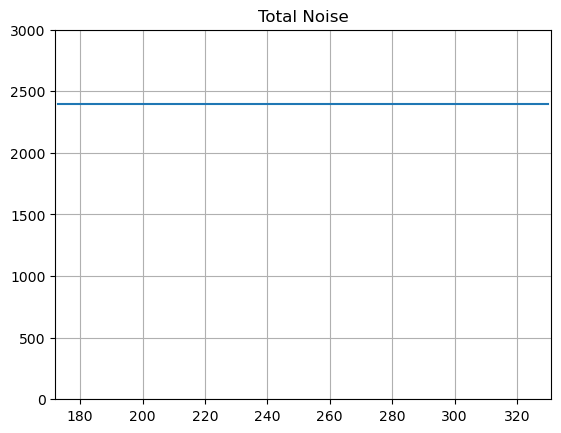

In [54]:
from numpy import linspace
T = linspace(173,330,158);    # K
# Calculamos la variación del ruido total con la temperatura para un intervalo 173 K a 330 K
def N_T_Total (T, t_i):
    # global N_q, N_r
    n = sqrt(N_q**2 + N_r**2 + N_f_R(t_i)**2+N_dark(T, t_i));
    return n
N_Total = N_T_Total(T,1);
# ndark = N_dark(T,1);

# Representamos el ruido total
import matplotlib.pyplot as plt
# figure(1)
plt.plot(T, N_Total)
plt.title('Total Noise')
plt.xlim(min(T)-1, max(T)+1)
plt.ylim(0, 3000)
plt.grid(visible=1)
plt.show()

Niveles de ruido esperados para la temperatura de operación T = 233 K

In [55]:
T_op1 = 233;       t_in = [1.5, 1, 0.5, 1.25*1e-3];
N_Total_233K = N_T_Total(T_op1, t_in);

Niveles de ruido esperados para la temperatura de operación T = 263 K

In [56]:
T_op2 = 263;       
N_Total_263K = N_T_Total(T_op2, t_in);


## Evaluación de SNR para un cierto nivel de señal (Detección Continua)

In [57]:
T = linspace(193, 293, 101);       
t_i1 = 0.1;     t_i2 = 0.05;    t_i3 = 0.02;    t_i4 = 0.01;
# SNR
def SNR_REAL(T, t_i):
    global Signal 
    s = Signal / N_T_Total(T, t_i);
    return s
SNR_real_1 = SNR_REAL(T, t_i1);
SNR_real_2 = SNR_REAL(T, t_i2);
SNR_real_3 = SNR_REAL(T, t_i3);
SNR_real_4 = SNR_REAL(T, t_i4);

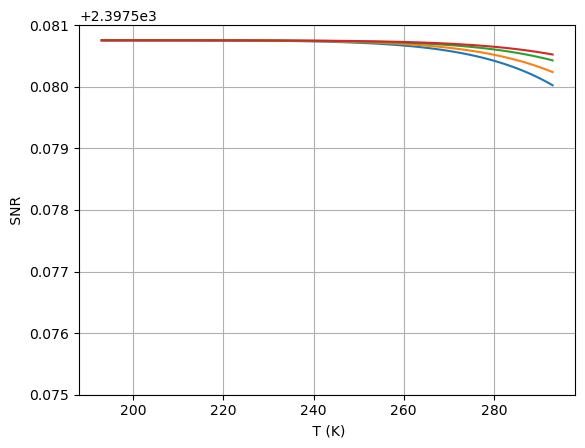

In [58]:
plt.plot(T, SNR_real_1)
plt.plot(T, SNR_real_2)
plt.plot(T, SNR_real_3)
plt.plot(T, SNR_real_4)
plt.xlabel(' T (K)')
plt.ylabel(' SNR ')
plt.ylim(2397.575, 2397.581)
# plt.legend('SNR t=0.1', 'SNR t=0.05', 'SNR t=0.02', 'SNR t=0.01', 'Location', 'southwest')
# plt.legend(['SNR t=0.1', 'SNR t=0.05', 'SNR t=0.02', 'SNR t=0.01'], [SNR_real_1, SNR_real_2, SNR_real_3, SNR_real_4])
plt.grid(visible=1)
plt.show()


## Evaluación de SNR para un cierto nivel (Condición promedio)

Sea N el número de imágenes tomadas (acumulaciones).

In [60]:
NN = 20;   # Número de pulsos
# t_i = 0.1;
tau_ida_vuelta = 2*alcance*1e3 / c;
# SNR Average Condition
def SNR_REAL_A(T, t_i, N):
    # global Signal
    s = Signal * N / sqrt(N_T_Total(T, t_i)**2.*N);
    return s
SNR_real_A1 = SNR_REAL_A(T, t_i1, NN);
SNR_real_A2 = SNR_REAL_A(T, t_i2, NN);
SNR_real_A3 = SNR_REAL_A(T, t_i3, NN);
SNR_real_A4 = SNR_REAL_A(T, t_i4, NN);

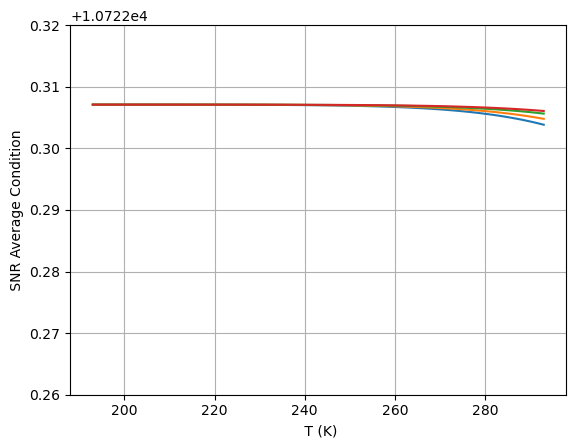

In [61]:
plt.plot(T, SNR_real_A1)
plt.plot(T, SNR_real_A2)
plt.plot(T, SNR_real_A3)
plt.plot(T, SNR_real_A4)
plt.xlabel(' T (K)')
plt.ylabel(' SNR Average Condition ')
plt.ylim([10722.26, 10722.32])
# plt.legend('SNR_A t=0.1', 'SNR_A t=0.05', 'SNR_A t=0.02', 'SNR_A t=0.01', 'Location', 'southwest')
plt.grid(visible=1)
plt.show()